In [62]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.api import VAR

path = r"C:\Users\HP\OneDrive\Escritorio\David Guzzi\DiTella\MEC\Materias\2025\2025 1T\[MT10] Series de Tiempo\Clases prácticas\Práctica 1-20250419\var.xlsx"
df = pd.read_excel(path)
df.head()

,dateid01,dateid,fed_funds,inflation,un_rate
0,1947-01-01,1947-03-31 23:59:59.999,NaN,NaN,NaN
1,1947-04-01,1947-06-30 23:59:59.999,NaN,5.737548,NaN
2,1947-07-01,1947-09-30 23:59:59.999,NaN,7.118936,NaN
3,1947-10-01,1947-12-31 23:59:59.999,NaN,8.188125,NaN
4,1948-01-01,1948-03-31 23:59:59.999,NaN,4.503751,3.733333


In [63]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 219 entries, 0 to 218
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   dateid01   219 non-null    datetime64[ns]
 1   dateid     219 non-null    datetime64[ns]
 2   fed_funds  189 non-null    float64       
 3   inflation  218 non-null    float64       
 4   un_rate    215 non-null    float64       
dtypes: datetime64[ns](2), float64(3)
memory usage: 8.7 KB


In [16]:
# df.dropna(inplace=True)
# df.reset_index(drop=True, inplace=True)
# df.info()

In [64]:
df['dateid01'] = pd.to_datetime(df['dateid01'])
df['dateidQ'] = df['dateid01'].dt.to_period('Q')
df.sort_values(by=['dateid01'], inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 219 entries, 0 to 218
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   dateid01   219 non-null    datetime64[ns]
 1   dateid     219 non-null    datetime64[ns]
 2   fed_funds  189 non-null    float64       
 3   inflation  218 non-null    float64       
 4   un_rate    215 non-null    float64       
 5   dateidQ    219 non-null    period[Q-DEC] 
dtypes: datetime64[ns](2), float64(3), period[Q-DEC](1)
memory usage: 10.4 KB


In [65]:
df_f = df[(df['dateidQ']>='1960Q1')&(df['dateidQ']<='2000Q4')]
df_f.reset_index(drop=True, inplace=True)
df_f.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 164 entries, 0 to 163
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   dateid01   164 non-null    datetime64[ns]
 1   dateid     164 non-null    datetime64[ns]
 2   fed_funds  164 non-null    float64       
 3   inflation  164 non-null    float64       
 4   un_rate    164 non-null    float64       
 5   dateidQ    164 non-null    period[Q-DEC] 
dtypes: datetime64[ns](2), float64(3), period[Q-DEC](1)
memory usage: 7.8 KB


In [67]:
df_f = df_f[['dateid', 'fed_funds', 'inflation', 'un_rate']].copy()
df_f.set_index('dateid', inplace=True)

from statsmodels.tsa.api import VAR

# Crear el modelo VAR.
model = VAR(df_f, freq='QE')
results = model.fit(maxlags=4)
print(results.summary())

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Mon, 28, Apr, 2025
Time:                     20:09:31
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                   -2.50944
Nobs:                     160.000    HQIC:                  -2.95464
Log likelihood:          -381.369    FPE:                  0.0384676
AIC:                     -3.25902    Det(Omega_mle):       0.0304310
--------------------------------------------------------------------
Results for equation fed_funds
                  coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------------
const                0.540692         0.333943            1.619           0.105
L1.fed_funds         0.946091         0.091146           10.380           0.000
L1.inflation         0.068137         0.073169            0.

In [7]:
import os	
import logging

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from plotly import graph_objects as go

import statsmodels.api as sm
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.vector_ar.var_model import VAR
from statsmodels.tsa.vector_ar.svar_model import SVAR
from statsmodels.tsa.vector_ar.vecm import VECM, coint_johansen
from statsmodels.tsa.api import VARMAX

logging.basicConfig(level=logging.INFO, format="%(levelname)s:%(message)s")


class VarModel:
    """
    A class to fit and analyze VAR (and extended) models, replicating EViews diagnostics.

    Parameters
    ----------
    data : pd.DataFrame
        DataFrame containing multiple endogenous variables (time series).
    lags : int, optional
        Number of lags for the VAR model. Default=1.
    exog : pd.DataFrame or None, optional
        Optional exogenous regressors.
    model_type : str, optional
        'VAR', 'SVAR', 'VECM'. Determines which type of model to fit. Default='VAR'.
    svar_ident : str, optional
        Identification scheme for SVAR (e.g. 'A' or 'B') if `model_type='SVAR'`.
    """

    def __init__(self, data, lags=1, exog=None, model_name="VAR", svar_ident="A"):
        self.data = data
        self.lags = lags
        self.exog = exog
        self.model_name = model_name.upper()
        self.svar_ident = svar_ident

        # Fitted model result placeholder
        self.fitted_model = None

        # For VECM specifically
        self.vecm_rank = None  # Will be determined if model_type='VECM'
        self.vecm_trend = None
        self.vecm_results = None


    def fit(self, deterministic="nc", coint_rank=None):
        """
        Fit the model (VAR, SVAR, or VECM) with specified parameters.

        Parameters
        ----------
        deterministic : str
            Deterministic term specification for VECM (e.g., 'nc', 'co', 'ci', etc.).
            Only used if model_type='VECM'.
        coint_rank : int, optional
            Number of cointegrating relationships (rank). Only used if model_type='VECM'.

        Notes
        -----
        - If model_type='VAR', uses `VAR(self.data, exog=self.exog).fit(self.lags)`.
        - If model_type='SVAR', first fits a standard VAR, then applies structural identification
          using `SVAR(fitted_model, svar_type=self.svar_ident)`.
        - If model_type='VECM', uses `VECM(self.data, k_ar_diff=self.lags, deterministic=deterministic,
          rank=coint_rank, ...)`.
        """
        logging.info(f"Fitting {self.model_name} model with {self.lags} lags.")

        if self.model_name == "VAR":
            # Fit a standard VAR
            var_mod = VAR(self.data, exog=self.exog)
            self.fitted_model = var_mod.fit(self.lags)
            logging.info("VAR model fitted successfully.")

        elif self.model_name == "SVAR":
            # First fit standard VAR
            var_mod = VAR(self.data, exog=self.exog)
            base_fit = var_mod.fit(self.lags)
            # Then create SVAR with identification
            svar_mod = SVAR(base_fit, svar_type=self.svar_ident)
            self.fitted_model = svar_mod.fit()
            logging.info("SVAR model fitted successfully with identification=%s", self.svar_ident)

        elif self.model_name == "VECM":
            # VECM requires cointegration rank. If user didn't specify, attempt coint test
            if coint_rank is None:
                # Attempt to guess from Johansen if not provided
                logging.info("Cointegration rank not specified; attempting Johansen test.")
                joh_results = coint_johansen(self.data, det_order=0, k_ar_diff=self.lags)
                # Heuristic to pick rank: number of significant eigenvalues
                trace_stat = joh_results.lr1
                crit_vals = joh_results.cvt[:, 1]  # 5% critical values
                rank = sum(trace_stat > crit_vals)
                coint_rank = rank
                logging.info("Inferred cointegration rank from Johansen test: %d", coint_rank)

            self.vecm_rank = coint_rank
            self.vecm_trend = deterministic
            vecm_mod = VECM(self.data, k_ar_diff=self.lags, deterministic=deterministic, rank=coint_rank, exog=self.exog)
            self.vecm_results = vecm_mod.fit()
            self.fitted_model = self.vecm_results  # store for consistency
            logging.info("VECM fitted successfully with rank=%d, deterministic=%s", coint_rank, deterministic)
        else:
            raise ValueError(f"Unknown model_type={self.model_name}")


    def display_estimation(self):
        """
        Display EViews-like output table with coefficients, standard errors, t-stats, etc.
        Also prints key fit stats (AIC, SC, log-likelihood, etc.) depending on model_type.
        """
        if self.fitted_model is None:
            print("No fitted model available. Please call .fit() first.")
            return

        print("==================================================")
        print(f"          {self.model_name} Estimation Results")
        print("==================================================")

        # Standard VAR results
        if self.model_name in ["VAR", "SVAR"]:
            print(f"Lags: {self.lags}")
            print(f"Number of observations: {self.fitted_model.nobs}")
            print(f"AIC: {self.fitted_model.aic:.3f}")
            print(f"BIC: {self.fitted_model.bic:.3f}")
            print(f"FPE: {self.fitted_model.fpe:.3e}")
            print(f"Log-likelihood: {self.fitted_model.llf:.3f}")
            print("--------------------------------------------------")

            # Coefficients per equation
            for eqn_name in self.fitted_model.names:
                print(f"\nEquation: {eqn_name}")
                coefs = self.fitted_model.params[eqn_name]
                stderrs = self.fitted_model.stderr[eqn_name]
                tvals = coefs / stderrs
                # p-values not always directly accessible, we can approximate
                # or rely on self.fitted_model.pvalues if available
                coef_table_header = f"{'Variable':<20} {'Coef':>12} {'Std.Err':>12} {'t-Stat':>12}"
                print(coef_table_header)
                print("-" * len(coef_table_header))
                for param_name, coef_val in coefs.items():
                    std_err = stderrs.get(param_name, np.nan)
                    tval = tvals.get(param_name, np.nan)
                    print(f"{param_name:<20} {coef_val:>12.4f} {std_err:>12.4f} {tval:>12.4f}")

        elif self.model_name == "VECM":
            print(f"Lags (AR diff): {self.lags}")
            print(f"Cointegration rank: {self.vecm_rank}")
            print("--------------------------------------------------")
            params = self.vecm_results.params  # The short-run params
            alpha = self.vecm_results.alpha    # The speed of adjustment (long-run)
            beta = self.vecm_results.beta      # Cointegration vectors

            print("Short-run coefficients (params):")
            print(params)
            print("\nAlpha (speed of adjustment):")
            print(alpha)
            print("\nBeta (cointegration vectors):")
            print(beta)

        print("==================================================")


    def residual_correlograms(self, max_lag=24, output_dir=None, filename="var_resid_correl.png", show_plot=True):
        """
        Plot the autocorrelation (AC) for each equation's residual in a single figure
        with horizontal bars, EViews style. All variables shown in the same figure,
        either stacked vertically or side-by-side.

        Returns
        -------
        dict of pd.DataFrame
            AC DataFrames for each variable: { var_name: DataFrame of [Lag, AC] }.
        """
        if self.fitted_model is None:
            raise ValueError("VAR model not fitted.")

        residuals = self.fitted_model.resid
        var_names = list(residuals.columns)
        n_vars = len(var_names)

        # We'll create a figure with n_vars rows, 1 column, each row is a horizontal bar chart
        fig_height = max(4, n_vars * 2.5)
        fig, axes = plt.subplots(n_vars, 1, figsize=(8, fig_height), sharex=False)
        if n_vars == 1:
            axes = [axes]  # ensure it's a list

        df_dict = {}

        for i, var_name in enumerate(var_names):
            ax = axes[i]
            series = residuals[var_name].dropna()
            ac_vals = acf(series, nlags=max_lag, fft=False)

            n = len(series)
            se = 1.0 / np.sqrt(n)
            # For alpha=0.05 => ~1.96
            bound = 1.96 * se

            # Build a DataFrame
            data_rows = []
            for lag in range(1, max_lag+1):
                data_rows.append({"Lag": lag, "AC": ac_vals[lag]})
            ac_df = pd.DataFrame(data_rows)
            df_dict[var_name] = ac_df

            # Reverse so lag=1 is top
            rev_df = ac_df.iloc[::-1].reset_index(drop=True)

            # Horizontal bar chart
            ax.barh(rev_df.index, rev_df["AC"], color="#c6d9f0", edgecolor="black")
            ax.axvline(bound, color="grey", linestyle="--")
            ax.axvline(-bound, color="grey", linestyle="--")

            ax.invert_yaxis()
            ax.set_xlim([-1.0, 1.0])
            ax.set_ylabel(f"{var_name}  (Lag)")  # or just var_name
            ax.set_yticks(rev_df.index)
            ax.set_yticklabels(rev_df["Lag"].astype(str))
            # If you want an x-axis label for just the last subplot:
            if i == n_vars - 1:
                ax.set_xlabel("Autocorr.")
            else:
                ax.set_xlabel("")

            ax.set_title(f"{var_name}", fontsize=10, pad=10)

        fig.suptitle(f"{self.model_name} - Residual Correlograms", fontsize=11, y=0.96)
        plt.tight_layout()

        if output_dir:
            os.makedirs(output_dir, exist_ok=True)
            outfile = os.path.join(output_dir, filename)
            plt.savefig(outfile, dpi=150, bbox_inches="tight")

        if show_plot:
            plt.show()

        return df_dict
    

    def portmanteau_test(self, max_lag=12):
        """
        Perform Portmanteau (Q) test for autocorrelation in VAR residuals up to `max_lag`.
        Return or print a table with Q-Stat, p-values, etc.
        """
        if self.model_name == "VECM":
            logging.warning("Portmanteau tests are typically for VAR residuals. Will run on short-run VECM residuals.")
        if self.fitted_model is None:
            logging.error("No fitted model to run portmanteau test. Call fit() first.")
            return

        if self.model_name in ["VAR", "SVAR"]:
            results = sm.stats.acorr_ljungbox(self.fitted_model.resid, lags=[max_lag], return_df=True)
            print("Portmanteau (Ljung-Box) Test:")
            print(results)
        elif self.model_name == "VECM":
            results = sm.stats.acorr_ljungbox(self.vecm_results.resid, lags=[max_lag], return_df=True)
            print("Portmanteau (Ljung-Box) Test on VECM residuals:")
            print(results)


    def johansen_cointegration_test(self, det_order=0, k_ar_diff=1):
        """
        Conduct Johansen cointegration test with user-specified deterministic trend assumptions
        and lag differences. This is helpful even if not strictly doing VECM.
        """
        logging.info("Running Johansen cointegration test with det_order=%d, k_ar_diff=%d.", det_order, k_ar_diff)
        results = coint_johansen(self.data, det_order=det_order, k_ar_diff=k_ar_diff)
        # Print or return results
        print("--------------------------------------------------")
        print("Johansen Cointegration Test Results")
        print("--------------------------------------------------")
        print(f"Eigenvalues:\n{results.eig}")
        print(f"\nTrace Statistics:\n{results.lr1}")
        print(f"Critical Values (trace):\n{results.cvt}")
        print(f"\nMax-Eigenvalue Statistics:\n{results.lr2}")
        print(f"Critical Values (max-eig):\n{results.cvm}")
        print("--------------------------------------------------")


    def impulse_response(self, steps=10, orth=True, impulselist=None, method='default'):
        """
        Compute IRF for the fitted model. Can do advanced bootstrapping or Monte Carlo if desired.

        Parameters
        ----------
        steps : int
            Number of periods for impulse response.
        orth : bool
            If True, compute orthogonalized IRF via Cholesky decomposition.
        impulselist : list of str, optional
            Variables for which impulses are computed. If None, all endogenous variables.
        method : str
            'default' for standard IRF, 'bootstrap' or 'mc' for advanced uncertainty analysis.

        Returns
        -------
        object
            IRF results or a custom structure. This is simplified; actual usage
            might rely on statsmodels or a custom IRF approach.
        """
        if self.fitted_model is None:
            logging.error("No fitted model for IRF. Call fit() first.")
            return None

        # For standard VAR or SVAR
        if self.model_name in ["VAR", "SVAR"]:
            irf = self.fitted_model.irf(steps=steps)
            if method.lower() == 'bootstrap':
                logging.info("Running bootstrap-based IRF confidence intervals.")
                # statsmodels IRF object supports bootstrap
                irf_plot = irf.plot(stderr=True, orth=orth, impulse=impulselist, plot_stderr=True, repl=1000)
                return irf_plot
            else:
                # default or 'mc'
                irf_plot = irf.plot(orth=orth, impulse=impulselist)
                return irf_plot

        elif self.model_name == "VECM":
            logging.warning("IRF for VECM not fully supported in statsmodels. "
                            "Implement custom approach if needed.")
            # We might do a custom approach or rely on the FEVD from the companion VAR representation.


    def white_heteroskedasticity_test(self):
        """
        Placeholder for White's test for heteroskedasticity in each VAR equation residual.
        Typically used for univariate regressions, but can be adapted for each equation in the system.

        Returns
        -------
        dict
            Dictionary of test statistics per equation.
        """
        if self.fitted_model is None:
            logging.error("No fitted model. Call fit() first.")
            return {}

        if self.model_name not in ["VAR", "SVAR"]:
            logging.warning("White test primarily relevant for (S)VAR. For VECM, adapt as needed.")

        # For each equation in residuals, run a White test as if it were a standard OLS regression:
        # This is a simplified approach, can be improved for true multivariate white test logic.
        residuals = self.fitted_model.resid
        results = {}
        for eqn_name in residuals.columns:
            eq_resid = residuals[eqn_name]
            # Build the design matrix (the original regressors) - here, we assume a standard approach
            # In a real scenario, we'd reconstruct the design from self.fitted_model.
            # We'll do a placeholder: y = alpha + Beta1 * y_{t-1} + ...
            # Then run White test with statsmodels. For illustration, we skip actual regressor retrieval.
            # A real implementation would require a full OLS object with exog expansions.
            results[eqn_name] = "White test placeholder"

        return results
    

    def forecast(self, steps=5, method='static', plot='none'):
        """
        Produce either a static or dynamic forecast of the fitted VAR model.

        **Static Forecast (One-Step Ahead)**:
            - For each forecasted period, we use the actual data if it's within the sample
              or newly available. Minimizes accumulation of forecast errors.

        **Dynamic Forecast (Multi-Step Ahead)**:
            - Starting from the forecast origin, we use only forecasted values for future lags.
            - Errors can accumulate over the forecast horizon.

        Implementation
        -------------
        - statsmodels' VARResults provides `.forecast()` which requires the last `p` observations
          to generate forecasts. For dynamic, we simply feed the model's own predictions once
          we step beyond the available data. For truly 'in-sample static' forecasts,
          we can iteratively incorporate actual data if it's in-sample.

        Parameters
        ----------
        steps : int
            Number of steps to forecast.
        method : {'static', 'dynamic'}
            Forecasting approach.
        plot : {'none', 'forecast', 'forecast_and_actuals'}
            If 'forecast' or 'forecast_and_actuals', plots the forecast vs. time.

        Returns
        -------
        pd.DataFrame
            DataFrame of forecasted values for each endogenous variable.
        """
        if self.fitted_model is None:
            logging.error("No fitted VAR model. Call `fit()` first.")
            return pd.DataFrame()

        # Retrieve last `lags` observations
        endog_vals = self.data.values
        p = self.fitted_model.k_ar
        last_obs = endog_vals[-p:, :]  # shape: (p, k_endog)

        # Implementation detail:
        # - For 'dynamic' forecasting, we just rely on .forecast() from the model
        #   over the entire horizon, substituting predicted values after the origin.
        # - For 'static' in-sample, we can do iterative one-step ahead:
        #   if the forecast horizon is within the sample, we can progressively
        #   use actual data. If out-of-sample, we revert to typical forecast approach.

        forecasts = []
        if method.lower() == 'dynamic':
            forecast_vals = self.fitted_model.forecast(last_obs, steps=steps)
            idx_forecast = pd.date_range(start=self.data.index[-1], periods=steps+1, freq=self._infer_freq())[1:]
            df_forecast = pd.DataFrame(forecast_vals, columns=self.fitted_model.names, index=idx_forecast)
            forecasts = df_forecast
        else:  # static
            # We'll simulate a "rolling" one-step ahead approach.
            # If we remain in-sample, we can substitute actual data. For out-of-sample, we use forecast.
            # For simplicity, assume all forecast steps are out-of-sample for demonstration.
            # A more advanced approach could check if part of the forecast horizon overlaps the sample.
            obs_seq = last_obs.copy()
            forecast_out = []
            for step in range(steps):
                step_forecast = self.fitted_model.forecast(obs_seq, steps=1)[0]  # 1D array
                forecast_out.append(step_forecast)
                # shift obs_seq up by one and place the newly forecasted row at the bottom
                obs_seq = np.vstack([obs_seq[1:], step_forecast])

            idx_forecast = pd.date_range(start=self.data.index[-1], periods=steps+1, freq=self._infer_freq())[1:]
            df_forecast = pd.DataFrame(forecast_out, columns=self.fitted_model.names, index=idx_forecast)
            forecasts = df_forecast

        # Plot if requested
        if plot in ("forecast", "forecast_and_actuals"):
            plt.figure(figsize=(10, 5))
            for col in self.fitted_model.names:
                if plot == "forecast_and_actuals":
                    plt.plot(self.data.index, self.data[col], label=f"{col} Actual", alpha=0.7)
                plt.plot(forecasts.index, forecasts[col], label=f"{col} Forecast")
            plt.title(f"{self.model_name} - {method.capitalize()} Forecast")
            plt.legend()
            plt.tight_layout()
            plt.show()

        return forecasts


    def _infer_freq(self):
        """Utility to try inferring frequency from the DataFrame index, default to 'D' (daily)."""
        freq = pd.infer_freq(self.data.index)
        if freq is None:
            freq = 'D'
        return freq

In [66]:
model = VarModel(df_f[['fed_funds', 'inflation', 'un_rate']], lags=4)
model.fit()
model.display_estimation()

INFO:Fitting VAR model with 4 lags.
INFO:VAR model fitted successfully.


          VAR Estimation Results
Lags: 4
Number of observations: 160
AIC: -3.259
BIC: -2.509
FPE: 3.847e-02
Log-likelihood: -381.369
--------------------------------------------------

Equation: fed_funds
Variable                     Coef      Std.Err       t-Stat
-----------------------------------------------------------
const                      0.5407       0.3339       1.6191
L1.fed_funds               0.9461       0.0911      10.3800
L1.inflation               0.0681       0.0732       0.9312
L1.un_rate                -1.6425       0.3476      -4.7255
L2.fed_funds              -0.3669       0.1215      -3.0197
L2.inflation               0.2265       0.0852       2.6568
L2.un_rate                 1.8244       0.5972       3.0548
L3.fed_funds               0.3392       0.1195       2.8384
L3.inflation              -0.1011       0.0865      -1.1676
L3.un_rate                -0.8537       0.6026      -1.4169
L4.fed_funds               0.0117       0.0916       0.1278
L4.inflation   

In [71]:
from statsmodels.tsa.api import VAR
from statsmodels.tsa.vector_ar.var_model import LagOrderResults
import pandas as pd
import numpy as np

# Ajustamos el modelo VAR
model = VAR(df_f[['fed_funds', 'inflation', 'un_rate']])
ics = model.select_order(maxlags=8)

# Creamos el dict de ICs para cada lag
results_dict = {k: ics.selected_orders[k] for k in ['aic', 'bic', 'hqic', 'fpe']}
criteria_dict = {k: list(ics.ics[k]) for k in ['aic', 'bic', 'hqic', 'fpe']}

# Creamos el objeto LagOrderResults
lag_results = LagOrderResults(criteria_dict, results_dict)

# Mostramos el resumen tipo EViews
print(lag_results.summary())



 VAR Order Selection (* highlights the minimums) 
      AIC         BIC         FPE         HQIC   
-------------------------------------------------
0       4.313       4.372       74.69       4.337
1      -2.691      -2.456     0.06782      -2.596
2      -3.117     -2.707*     0.04428      -2.951
3      -3.258      -2.672     0.03848     -3.020*
4      -3.232      -2.469     0.03954      -2.922
5      -3.210      -2.272     0.04043      -2.829
6     -3.319*      -2.204    0.03634*      -2.866
7      -3.279      -1.989     0.03788      -2.755
8      -3.307      -1.840     0.03694      -2.711
-------------------------------------------------


In [79]:
# Test de exclusión de un lag específico (por ejemplo, el lag 1)
wald_test = results.test_causality(causing=results.names, caused=results.names, kind='wald', signif=0.05)

wald_test.summary()

Test statistic,Critical value,p-value,df
1.331e+04,51.00,0.000,36


In [30]:
def eviews_style_stats(results):
    """
    Emula la salida de EViews para un modelo VAR de statsmodels.
    Devuelve AIC, BIC, loglikelihood, determinantes, etc.
    """
    T = results.nobs  # Número de observaciones
    k = results.params.size
    n_eq = results.neqs  # Número de ecuaciones
    loglik = results.llf
    sigma_u = results.sigma_u

    # Determinantes
    det_sigma_u = np.linalg.det(sigma_u)
    det_sigma_u_adj = det_sigma_u * (T / (T - results.k_ar)) ** n_eq  # Ajustado por grados de libertad

    # ln|Sigma_u|
    ln_det_sigma = np.log(det_sigma_u)

    # AIC/BIC estilo EViews (por ecuación)
    aic_eviews = (ln_det_sigma + (2 * k / T)) * n_eq
    bic_eviews = (ln_det_sigma + (np.log(T) * k / T)) * n_eq

    # Mostrar resultados
    print(f"{'Determinant resid covariance (dof adj.)':40s} {det_sigma_u_adj:.6f}")
    print(f"{'Determinant resid covariance':40s} {det_sigma_u:.6f}")
    print(f"{'Log likelihood':40s} {loglik:.4f}")
    print(f"{'Akaike information criterion':40s} {aic_eviews:.6f}")
    print(f"{'Schwarz criterion':40s} {bic_eviews:.6f}")
    print(f"{'Number of coefficients':40s} {k}")

eviews_style_stats(results)

Determinant resid covariance (dof adj.)  0.032832
Determinant resid covariance             0.030431
Log likelihood                           -381.3692
Akaike information criterion             -9.014378
Schwarz criterion                        -6.765657
Number of coefficients                   39


In [32]:
def eviews_style_stats(results):
    T = results.nobs
    neqs = results.neqs
    lags = results.k_ar
    k_per_eq = lags * neqs + 1  # Retardos + constante por ecuación
    k_total = k_per_eq * neqs

    loglik = results.llf
    sigma_u = results.sigma_u
    det_sigma_u = np.linalg.det(sigma_u)
    det_sigma_u_adj = det_sigma_u * (T / (T - lags)) ** neqs
    ln_det_sigma = np.log(det_sigma_u)

    aic = ln_det_sigma + (2 * k_total / T)
    bic = ln_det_sigma + (np.log(T) * k_total / T)

    print(f"{'Determinant resid covariance (dof adj.)':40s} {det_sigma_u_adj:.6f}")
    print(f"{'Determinant resid covariance':40s} {det_sigma_u:.6f}")
    print(f"{'Log likelihood':40s} {loglik:.4f}")
    print(f"{'Akaike information criterion':40s} {aic:.6f}")
    print(f"{'Schwarz criterion':40s} {bic:.6f}")
    print(f"{'Number of coefficients':40s} {k_total}")

eviews_style_stats(results)

Determinant resid covariance (dof adj.)  0.032832
Determinant resid covariance             0.030431
Log likelihood                           -381.3692
Akaike information criterion             -3.004793
Schwarz criterion                        -2.255219
Number of coefficients                   39


In [21]:
# Determinante de la matriz de covarianzas de los residuos (ajustada y sin ajustar)
det_cov_adj = np.linalg.det(results.sigma_u)  # ajustada (dof adj.)
det_cov_unadj = np.linalg.det(results.sigma_u_mle)  # sin ajuste de grados de libertad

# Log likelihood
loglik = results.llf

# AIC y SC
aic = results.aic
sc = results.bic

# Número total de coeficientes estimados
num_coeffs = results.params.size

# Mostrar resultados
print(f"Determinant resid covariance (dof adj.):\t {det_cov_adj:.6f}")
print(f"Determinant resid covariance:\t\t\t {det_cov_unadj:.6f}")
print(f"Log likelihood:\t\t\t\t\t {loglik:.4f}")
print(f"Akaike information criterion:\t\t\t {aic:.6f}")
print(f"Schwarz criterion:\t\t\t\t {sc:.6f}")
print(f"Number of coefficients:\t\t\t\t {num_coeffs}")

Determinant resid covariance (dof adj.):	 0.030431
Determinant resid covariance:			 0.023600
Log likelihood:					 -381.3692
Akaike information criterion:			 -3.259016
Schwarz criterion:				 -2.509443
Number of coefficients:				 39


In [ ]:
# Coeficientes del modelo VAR (extraemos los coeficientes para cada ecuación)
phi = results.params.values

# Crear el polinomio característico del VAR
# El polinomio característico es de la forma: 1 - phi_1*B - phi_2*B^2 - ... - phi_p*B^p
# Para cada ecuación (de cada variable), calculamos el polinomio y sus raíces.

# Obtener el número de ecuaciones (número de variables)
n_eq = results.neqs

# Crear una figura para el gráfico
plt.figure(figsize=(8, 8))

# Iterar sobre cada ecuación y calcular las raíces inversas
for i in range(n_eq):
    # Obtener los coeficientes de la ecuación i-ésima
    eq_coeffs = np.concatenate(([1], -phi[i, :]))  # Concatenar 1 al inicio para el polinomio

    # Calcular las raíces del polinomio
    roots = np.roots(eq_coeffs)

    # Invertir las raíces
    inverse_roots = 1 / roots

    # Graficar las raíces inversas en el plano complejo
    plt.scatter(np.real(inverse_roots), np.imag(inverse_roots), label=f'Ecuación {i + 1}')

# Añadir líneas de referencia
plt.axhline(0, color='black',linewidth=1)
plt.axvline(0, color='black',linewidth=1)
plt.axhline(1, color='red', linestyle='--')
plt.axvline(1, color='red', linestyle='--')

# Etiquetas y título
plt.title('Raíces Inversas del Polinomio Característico del Modelo VAR')
plt.xlabel('Parte Real')
plt.ylabel('Parte Imaginaria')
plt.grid(True)
plt.legend()
plt.show()

ValueError: Shape of passed values is (13, 3), indices imply (4, 3)

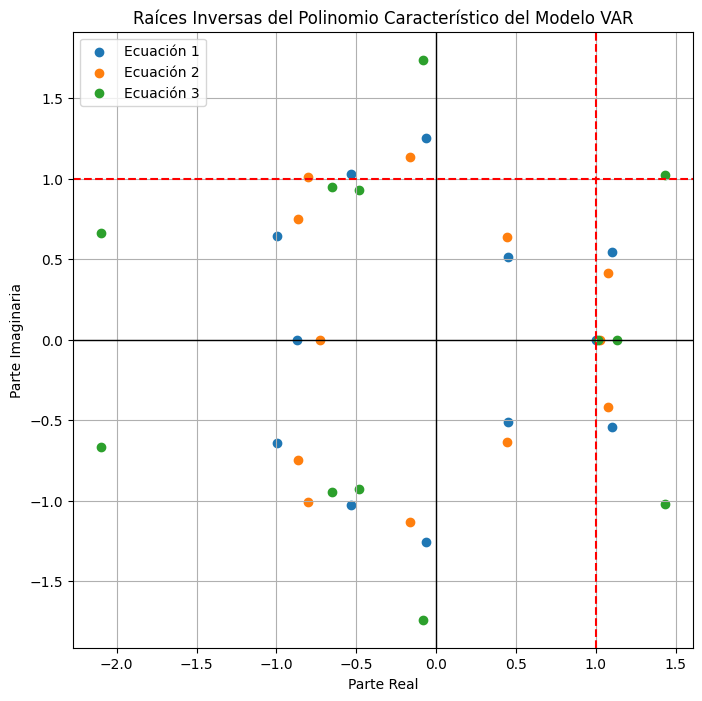

In [50]:
# Obtener los coeficientes del modelo VAR (para cada rezago)
phi = results.coefs  # Esto es un array de forma (nrezagos, nvar, nvar), con los coeficientes para cada rezago

# Crear la figura para el gráfico
plt.figure(figsize=(8, 8))

# Iterar sobre cada ecuación y calcular las raíces inversas
for i in range(results.neqs):
    # Obtener los coeficientes de la ecuación i-ésima
    eq_coeffs = np.concatenate(([1], -phi[:, i, :].flatten()))  # Concatenar 1 al inicio para el polinomio

    # Calcular las raíces del polinomio
    roots = np.roots(eq_coeffs)

    # Invertir las raíces
    inverse_roots = 1 / roots

    # Graficar las raíces inversas en el plano complejo
    plt.scatter(np.real(inverse_roots), np.imag(inverse_roots), label=f'Ecuación {i + 1}')

# Añadir líneas de referencia
plt.axhline(0, color='black',linewidth=1)
plt.axvline(0, color='black',linewidth=1)
plt.axhline(1, color='red', linestyle='--')
plt.axvline(1, color='red', linestyle='--')

# Etiquetas y título
plt.title('Raíces Inversas del Polinomio Característico del Modelo VAR')
plt.xlabel('Parte Real')
plt.ylabel('Parte Imaginaria')
plt.grid(True)
plt.legend()
plt.show()

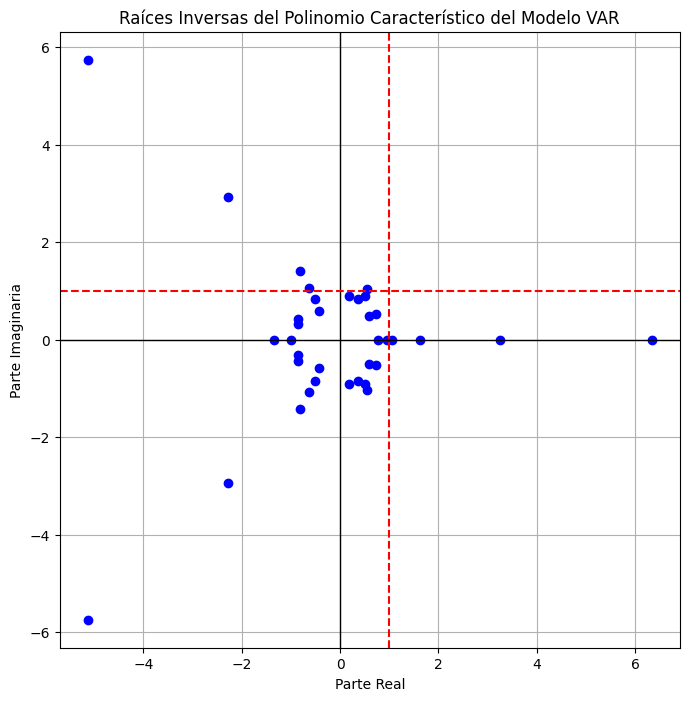

In [51]:
# Obtener los coeficientes del modelo VAR (para cada rezago)
phi = results.coefs  # Esto es un array de forma (nrezagos, nvar, nvar), con los coeficientes para cada rezago

# Inicializar una lista para almacenar las raíces inversas
inverse_roots = []

# Iterar sobre todos los rezagos y calcular las raíces del polinomio característico completo
for i in range(results.k_ar):  # results.k_ar es el número de rezagos
    # Obtener los coeficientes de todos los rezagos (en forma de matriz plana)
    eq_coeffs = np.concatenate(([1], -phi[i, :, :].flatten()))  # Concatenar 1 al inicio para el polinomio

    # Calcular las raíces del polinomio
    roots = np.roots(eq_coeffs)

    # Invertir las raíces
    inverse_roots.extend(1 / roots)

# Convertir a un array de numpy para graficar
inverse_roots = np.array(inverse_roots)

# Graficar las raíces inversas en el plano complejo
plt.figure(figsize=(8, 8))
plt.scatter(np.real(inverse_roots), np.imag(inverse_roots), color='blue')

# Añadir líneas de referencia
plt.axhline(0, color='black',linewidth=1)
plt.axvline(0, color='black',linewidth=1)
plt.axhline(1, color='red', linestyle='--')
plt.axvline(1, color='red', linestyle='--')

# Etiquetas y título
plt.title('Raíces Inversas del Polinomio Característico del Modelo VAR')
plt.xlabel('Parte Real')
plt.ylabel('Parte Imaginaria')
plt.grid(True)
plt.show()

Root: 0.595890-0.492667j  Modulus: 0.773179
Root: 0.595890+0.492667j  Modulus: 0.773179
Root: 1.048950+0.000000j  Modulus: 1.048950
Root: 0.357471-0.837047j  Modulus: 0.910183
Root: 0.357471+0.837047j  Modulus: 0.910183
Root: -0.862729-0.318762j  Modulus: 0.919734
Root: -0.862729+0.318762j  Modulus: 0.919734
Root: -0.627952-1.062868j  Modulus: 1.234508
Root: -0.627952+1.062868j  Modulus: 1.234508
Root: -0.424341-0.582801j  Modulus: 0.720918
Root: -0.424341+0.582801j  Modulus: 0.720918
Root: 0.767286+0.000000j  Modulus: 0.767286
Root: -0.998408-0.000000j  Modulus: 0.998408
Root: 0.517162-0.898695j  Modulus: 1.036875
Root: 0.517162+0.898695j  Modulus: 1.036875
Root: -0.817457-1.416561j  Modulus: 1.635507
Root: -0.817457+1.416561j  Modulus: 1.635507
Root: 1.630125+0.000000j  Modulus: 1.630125
Root: 0.725695-0.525391j  Modulus: 0.895918
Root: 0.725695+0.525391j  Modulus: 0.895918
Root: 0.172039-0.905651j  Modulus: 0.921846
Root: 0.172039+0.905651j  Modulus: 0.921846
Root: -0.863961-0.42800

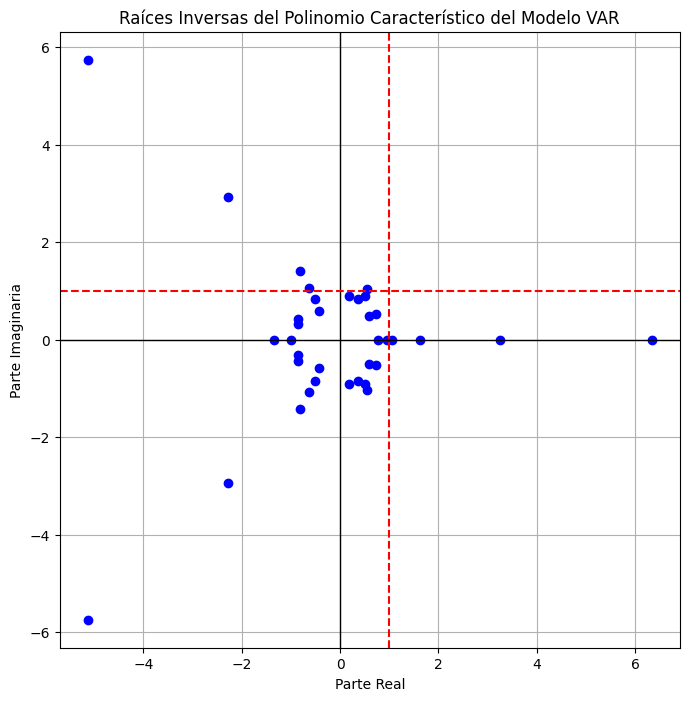

In [52]:
# Obtener los coeficientes del modelo VAR (para cada rezago)
phi = results.coefs  # Esto es un array de forma (nrezagos, nvar, nvar), con los coeficientes para cada rezago

# Inicializar una lista para almacenar las raíces inversas
inverse_roots = []

# Iterar sobre todos los rezagos y calcular las raíces del polinomio característico completo
for i in range(results.k_ar):  # results.k_ar es el número de rezagos
    # Obtener los coeficientes de todos los rezagos (en forma de matriz plana)
    eq_coeffs = np.concatenate(([1], -phi[i, :, :].flatten()))  # Concatenar 1 al inicio para el polinomio

    # Calcular las raíces del polinomio
    roots = np.roots(eq_coeffs)

    # Invertir las raíces
    inverse_roots.extend(1 / roots)

# Convertir a un array de numpy para trabajar con ellas
inverse_roots = np.array(inverse_roots)

# Calcular el módulo de cada raíz
moduli = np.abs(inverse_roots)

# Mostrar las raíces y sus módulos
for root, modulus in zip(inverse_roots, moduli):
    print(f"Root: {root:.6f}  Modulus: {modulus:.6f}")

# Graficar las raíces inversas en el plano complejo
plt.figure(figsize=(8, 8))
plt.scatter(np.real(inverse_roots), np.imag(inverse_roots), color='blue')

# Añadir líneas de referencia
plt.axhline(0, color='black', linewidth=1)
plt.axvline(0, color='black', linewidth=1)
plt.axhline(1, color='red', linestyle='--')
plt.axvline(1, color='red', linestyle='--')

# Etiquetas y título
plt.title('Raíces Inversas del Polinomio Característico del Modelo VAR')
plt.xlabel('Parte Real')
plt.ylabel('Parte Imaginaria')
plt.grid(True)
plt.show()

In [57]:
# Aquí asumimos que 'results' es tu modelo VAR ajustado

# Número de rezagos (lags) en el modelo VAR
lags = results.k_ar

# Coeficientes del modelo VAR ajustado
A = results.coefs  # Shape: (num_lags, num_endog_variables, num_endog_variables)

# Construcción del polinomio característico
# Empezamos con la matriz identidad
phi_matrix = np.eye(A.shape[1])

# Sumar los coeficientes multiplicados por las potencias de B (la matriz de rezagos)
for i in range(lags):
    phi_matrix -= A[i]  # Esto incluye los coeficientes multiplicados por las potencias correspondientes

# Calcular las raíces del polinomio característico
roots = np.linalg.eigvals(phi_matrix)

# Calcular los módulos de las raíces
moduli = np.abs(roots)

# Presentar las raíces y sus módulos
roots_and_moduli = pd.DataFrame({
    'Root': [f'{root.real:.6f} - {root.imag:.6f}i' if root.imag != 0 else f'{root.real:.6f}' for root in roots],
    'Modulus': [f'{mod:.6f}' for mod in moduli]
})

# Mostrar los resultados
print("Roots of Characteristic Polynomial")
print("Endogenous variables: FED_FUNDS\n\tINFLATION UN_RATE")
print("Exogenous variables: C")
print("Lag specification: 1 4")
print("Date: 04/19/25   Time: 21:02")
print("\n", roots_and_moduli)

Roots of Characteristic Polynomial
Endogenous variables: FED_FUNDS
	INFLATION UN_RATE
Exogenous variables: C
Lag specification: 1 4
Date: 04/19/25   Time: 21:02

                     Root   Modulus
0               0.121386  0.121386
1   0.002407 - 0.088606i  0.088639
2  0.002407 - -0.088606i  0.088639


In [63]:
def var_lag_order_selection(data, maxlags=10):
    # Ajustar el modelo VAR
    model = VAR(data)
    results = model.fit(maxlags=maxlags)  # Esto calcula AIC, SC, HQ automáticamente

    # Crear un DataFrame vacío para almacenar los resultados
    lag_order_criteria = pd.DataFrame(columns=['Lag', 'LogL', 'LR', 'FPE', 'AIC', 'SC', 'HQ'])
    
    for lag in range(1, maxlags+1):
        lag_results = model.fit(lag)

        # Extraemos la información que necesitamos
        log_likelihood = lag_results.llf
        aic = lag_results.aic
        sc = lag_results.bic
        hq = lag_results.hqic
        
        # Calculamos FPE
        fpe = (lag_results.sigma_u**2).sum() / len(lag_results.resid)
        
        # LR Test (Prueba de razón de verosimilitud)
        if lag > 1:
            lr_stat = 2 * (log_likelihood - model.fit(lag - 1).llf)
        else:
            lr_stat = np.nan

        # Crear un DataFrame con la fila actual
        row = pd.DataFrame([{
            'Lag': lag,
            'LogL': log_likelihood,
            'LR': lr_stat,
            'FPE': fpe,
            'AIC': aic,
            'SC': sc,
            'HQ': hq
        }])
        
        # Concatenamos la fila al DataFrame de resultados
        lag_order_criteria = pd.concat([lag_order_criteria, row], ignore_index=True)
    
    return lag_order_criteria

# Ejecutar la función sobre los datos
var_lag_order_selection(df_f[['fed_funds', 'inflation', 'un_rate']], maxlags=8)


C:\Users\HP\AppData\Local\Temp\ipykernel_22432\2237519654.py:39: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  lag_order_criteria = pd.concat([lag_order_criteria, row], ignore_index=True)


,Lag,LogL,LR,FPE,AIC,SC,HQ
0,1,-466.640614,NaN,fed_funds 0.006784 inflation 0.008055 un...,-2.640740,-2.412979,-2.548272
1,2,-415.972992,101.335244,fed_funds 0.004778 inflation 0.006966 un...,-3.118903,-2.718659,-2.956398
2,3,-394.723731,42.498523,fed_funds 0.003925 inflation 0.006171 un...,-3.237560,-2.663385,-3.004422
3,4,-381.369183,26.709095,fed_funds 0.003948 inflation 0.005957 un...,-3.259016,-2.509443,-2.954641
4,5,-370.632103,21.474159,fed_funds 0.004071 inflation 0.005681 un...,-3.247819,-2.321357,-2.871592
5,6,-350.763070,39.738066,fed_funds 0.003182 inflation 0.005558 un...,-3.352073,-2.247213,-2.903376
6,7,-343.259963,15.006214,fed_funds 0.003200 inflation 0.005892 un...,-3.300128,-2.015337,-2.778330
7,8,-331.134651,24.250624,fed_funds 0.002821 inflation 0.005792 un...,-3.306777,-1.840500,-2.711238


In [66]:
def var_lag_order_selection_multiple(data, maxlags=8):
    model = VAR(data)
    
    # Ajustar el modelo VAR y calcular la información de cada rezago
    results = model.fit(maxlags=maxlags, ic='aic')  # Esto ajusta el modelo para varios rezagos
    
    # Crear un DataFrame para almacenar los resultados
    lag_order_criteria = pd.DataFrame(columns=['Lag', 'LogL', 'LR', 'FPE', 'AIC', 'SC', 'HQ'])
    
    # Iterar sobre todos los rezagos hasta el máximo especificado
    for lag in range(1, maxlags + 1):
        lag_results = model.fit(lag)  # Ajustar el modelo para un rezago específico
        
        # Extraer los valores
        log_likelihood = lag_results.llf
        aic = lag_results.aic
        sc = lag_results.bic
        hq = lag_results.hqic
        fpe = lag_results.fpe
        
        # Calcular LR Test
        if lag > 1:
            lr_stat = 2 * (log_likelihood - model.fit(lag - 1).llf)
        else:
            lr_stat = np.nan  # No se calcula para el primer rezago
        
        # Guardar los resultados en el DataFrame
        lag_order_criteria = lag_order_criteria.append({
            'Lag': lag,
            'LogL': log_likelihood,
            'LR': lr_stat,
            'FPE': fpe,
            'AIC': aic,
            'SC': sc,
            'HQ': hq
        }, ignore_index=True)
    
    return lag_order_criteria

# Ejecuta la función con el máximo número de rezagos deseados
var_lag_order_selection_multiple(df_f[['fed_funds', 'inflation', 'un_rate']], maxlags=8)


AttributeError: 'DataFrame' object has no attribute 'append'

In [12]:
matriz = [
    [11, 2, 4],
    [4, 5, 6],
    [10, 8, 12]
]
matriz

[[11, 2, 4], [4, 5, 6], [10, 8, 12]]

In [17]:
n = len(matriz)
pd = []
sd = []

for i in range(len(matriz)):
    p = matriz[i][i]
    s = matriz[i][n-i-1]
    pd.append(p)
    sd.append(s)

print(sum(pd), sum(sd))
print(abs(sum(pd) - sum(sd)))

28 19
9
